# Gilbert Crew: Final Studio Analysis

### Analysis Introduction: 

Our group was tasked with diving into multiple data sets to provide analysis for Computing Vision, a company looking to get started with creating original video content. Our team combed through datasets from IMDB, Rotten Tomatoes, MOJO, and The Numbers to come up with three recommendations for Computing Vision based on various metrics. 

Some metrics we dive into include but are not limited to: 
* Movie Ratings/Popularity
* Net Income
* Movie Genre
* Movie Runtime
* Team Personel 

These metrics were selected because we believe they provide a helpful insight into creating the best possible studio and present guidlines on movie creation that will ultimately drive value for Computing Vision.

First, we will start our analysis by importing packages, and loading data needed for our analysis. 

In [25]:
#Importing neccesary packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from math import sqrt

In [26]:
#Loaded in relevant files from IMDB for main analysis
directors_file = "files/imbd_files/directors.csv"
known_for_file= "files/imbd_files/known_for.csv"
movie_akas_file = "files/imbd_files/movie_akas.csv"
movie_basics_file = "files/imbd_files/movie_basics.csv"
movie_ratings_file= "files/imbd_files/movie_ratings.csv"
persons_file = "files/imbd_files/persons.csv"
principals_file= "files/imbd_files/principals.csv"
writers_file = "files/imbd_files/writers.csv"
#Read files into dataframes
directors = pd.read_csv(directors_file)
known_for = pd.read_csv(known_for_file)
movie_akas = pd.read_csv(movie_akas_file)
movie_basics = pd.read_csv(movie_basics_file)
movie_ratings = pd.read_csv(movie_ratings_file)
persons = pd.read_csv(persons_file)
principals = pd.read_csv(principals_file)
writers = pd.read_csv(writers_file)
# Read in Data For Revenue Section
budgets = pd.read_csv('Files/tn.movie_budgets.csv.gz')

Setting up budget variable to be used in future analysis.

In [27]:
budgets['production_budget'] = budgets['production_budget'].str.replace('$','')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$','')
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace('$','')
budgets['production_budget'] = budgets['production_budget'].str.replace(',','')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',','')
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(',','')
budgets = budgets.drop(columns=['id', 'release_date'])
#Rename movie row to primary_title for consistency with previous tables
budgets = budgets.rename(columns={'movie': 'primary_title'})
budgets['production_budget'] = budgets['production_budget'].astype(float)
budgets['domestic_gross'] = budgets['domestic_gross'].astype(float)
budgets['worldwide_gross'] = budgets['worldwide_gross'].astype(float)
net = budgets.worldwide_gross - budgets.production_budget
budgets['net_revenue'] = net

### Recommendation #1: Movie Length

In this section we used statistical analysis to find out if there was correlation between movie length (minutes) and the top 100 best rated movies by rating.

We wanted to see if the difference in means between our sample of top rated movies and the population of movies on IMDB was significant so we decided to use a 1 tail T-test. 

To further our analysis, we also conducted a similar test by the top 100 net earning films as well.

### Code:

First, we needed to cleanup the data and merge movie_basics with movie_ratings to display the movie rating, and runtime metrics.

In [28]:
#Merged movie ratings with movie basics
movie_info = pd.merge(movie_basics, movie_ratings, how="inner", on='movie_id')

We then created the 'movies' and 'top_100_movies' variables to use in our analysis.

In [29]:
#Movies sort by most votes and avereage rating
top_movies = movie_info.sort_values(by=['numvotes', 'averagerating'], ascending=False)
#Top 100 movies selected
top_100_movies = top_movies.iloc[:100]
#Top 100 movies sorted specifically by movie rating
top_100_movies = top_100_movies.sort_values(by='averagerating', ascending=False)
#Index reseted for top 100 movies
top_100_movies = top_100_movies.reset_index().drop(columns='index')
#Select columns renamed for consistency among columns
top_100_movies = top_100_movies.rename(columns={'numvotes': 'num_votes', 'averagerating': 'avg_rating'})

#Adding a new variable 'movies' to manipulate
movies = top_movies.sort_values(by='averagerating', ascending=False)
movies = top_movies.reset_index().drop(columns='index')
movies = top_movies.rename(columns={'numvotes': 'num_votes', 'averagerating': 'avg_rating'})
movies.drop(labels=['primary_title', 'original_title', 'start_year', 'movie_id', 'genres', 'num_votes'], axis=1);
movies.isnull().sum()

movie_id              0
primary_title         0
original_title        0
start_year            0
runtime_minutes    7620
genres              804
avg_rating            0
num_votes             0
dtype: int64

From here, we know that the information we want to look at contains Null values. Because of this, we must clean the data for proper analysis. There are few factors for how we proceeded:

* We decided to drop the Null values in 'runtime_minutes' 
* If we replaced 'NaN' with the average our analysis would be similar but not truthful of actual runtime
* Used dropna to remove data

In [30]:
#Dropping 'Null' values
movies.dropna(axis=0, subset=['runtime_minutes'], inplace=True)

In [31]:
#Creates df with just the data we need
cleaned_movies = movies['runtime_minutes']

In order to make meaningful use of our data we needed to get rid of outliers. For example, one movie in the set was 50,000 minutes long and severely affected some results. We decided to use 99% of our data and set our percentiles to reflect all data between the bottom 1% and the top 99% to relfect a more accurate depiction of the movie population on IMDB. 

In [32]:
#Getting rid of outliers 
np.percentile(cleaned_movies, [1, 50, 99.4])
good_data = cleaned_movies[(cleaned_movies < 170) & (cleaned_movies > 45)]

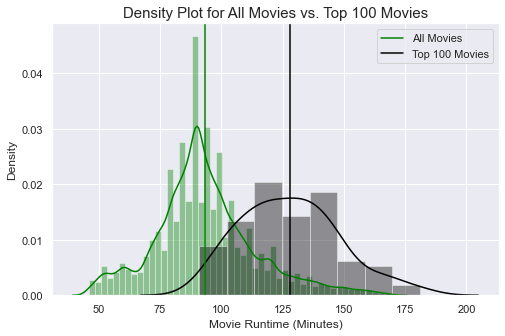

In [33]:
#Plotting all movies vs top 100 based on runtime
sns.color_palette("light:#5A9", as_cmap=True)
runcolor =top_100_movies['runtime_minutes']
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8,5)})
sns.distplot(good_data, color='Green')
sns.distplot(top_100_movies['runtime_minutes'], color='Black')#31a354
plt.xlabel("Movie Runtime (Minutes)", size=12)
plt.title("Density Plot for All Movies vs. Top 100 Movies", size=15)
plt.axvline(x=good_data.mean(), color='Green')
plt.axvline(x=runcolor.mean(), color='Black')
plt.legend(labels=(['All Movies','Top 100 Movies']));

Statistical test:

* Determined that one tail t-test would be the most beneficial
* Testing to see if the top 100 movies runtime is statistically significant

Null and Alternative Hypothesis:

* Top rated movies have the same runtime as all other movies on IMDB (null)
* Top rated movies do have a longer runtime than all other movies on IMBD (alternative)


In [53]:
sd = np.std(top_100_movies['runtime_minutes'], ddof=1)
mu = cleaned_movies.mean()
x_bar = top_100_movies['runtime_minutes'].mean()
n = 100
df = 99
alpha= 0.05
print('The standard deviation of the sample =', sd)
print('The mean of the population =', mu)
print('The mean of the sample is =', x_bar)
print('The number of observations is =', n)

The standard deviation of the sample = 20.002270073189397
The mean of the population = 94.6540400990398
The mean of the sample is = 127.99
The number of observations is = 100


The T-Statistic is = 16.666088288470306
The critical T value is = 1.6603911559963895
We reject the Null hypothesis because our T statistic is in the reject zone!


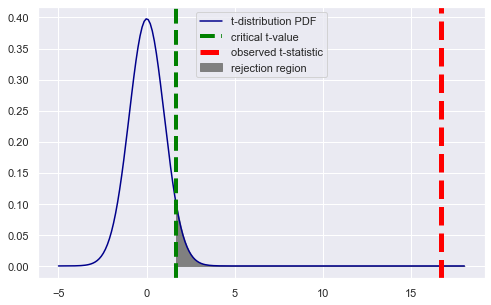

In [54]:
t_stat= (x_bar -  mu)/(sd/np.sqrt(n))
t_crit = st.t.ppf(1 - 0.05, df=99)
print('The T-Statistic is =', t_stat)
print('The critical T value is =', t_crit)
if t_stat <= t_crit:
    print('We fail to reject the Null hypothesis because our T statistic is less than the citical T value.')
else: 
    print('We reject the Null hypothesis because our T statistic is in the reject zone!')
    
fig, ax = plt.subplots(figsize=(8,5))

x = np.linspace(-5, 18, 200)
y = st.t.pdf(x, df, 0, 1)

ax.plot(x, y, color='darkblue', label="t-distribution PDF")
ax.axvline(t_crit,color='green',linestyle='--',lw=4,label='critical t-value')
ax.fill_betweenx(y,x,t_crit,where=x > t_crit,color="gray",label="rejection region")
ax.axvline(t_stat, color='Red', linestyle='--', lw=5,label='observed t-statistic')

ax.legend();

In [37]:
#Shows that our alpha of .05 is correct
st.t.cdf(t_crit, df=99)

0.9499999999979238

In [38]:
#Re-affirms findings that we reject Null
p_value = st.t.sf(t_stat, df=99)
p_value

8.619752364999059e-31

Our findings indicate that there is a correlation between movie run time and movie ratings. If Computing Vision can get there runtime to around 127 minutes reviews are likely to be better! Next, the following code will show if the highest net earning films have a similar result with respect to runtime.

In [40]:
second_suggestion = pd.merge(movie_info, budgets, how="inner", on='primary_title')
second_suggestion.isnull().sum()

movie_id               0
primary_title          0
original_title         0
start_year             0
runtime_minutes      118
genres                 8
averagerating          0
numvotes               0
production_budget      0
domestic_gross         0
worldwide_gross        0
net_revenue            0
dtype: int64

This data also has null values so we will remove them due to the same reasons as previously mentioned.

In [41]:
second_suggestion.dropna(axis=0, inplace=True)
top_100_rev = second_suggestion.sort_values(by='net_revenue',axis=0, ascending=False).iloc[:100]
top_100_runtime = top_100_rev['runtime_minutes']
rev_movies = second_suggestion['runtime_minutes']

Statistical test:

* Determined that one tail t-test would be the most beneficial
* Testing to see if the top 100 movies runtime is statistically significant

Null and Alt Hypothesis:

* The top net earning movies have the same runtime as all other movies on The Numbers Dataset (null)
* The top net earning movies do have a longer runtime than all other movies on The Numbers Dataset (alternative)

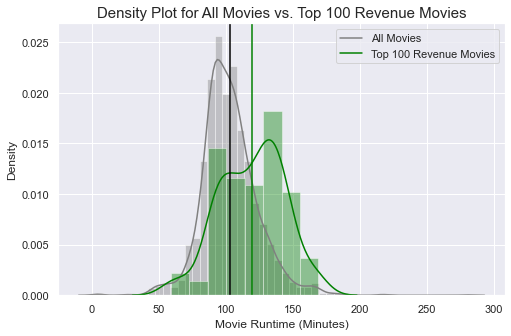

In [42]:
sns.distplot(rev_movies, color='Grey')
sns.distplot(top_100_runtime, color='Green')
plt.xlabel("Movie Runtime (Minutes)", size=12)
plt.title("Density Plot for All Movies vs. Top 100 Revenue Movies", size=15)
plt.axvline(x=top_100_runtime.mean(), color='Green')
plt.axvline(x=rev_movies.mean(), color='Black')
plt.legend(labels=(['All Movies','Top 100 Revenue Movies']));

In [46]:
sd = np.std(top_100_runtime, ddof=1)
mu = rev_movies.mean()
x_bar = top_100_runtime.mean()
n = 100
df = 99
alpha= 0.05
print('The standard deviation of the sample =', sd)
print('The mean of the population =', mu)
print('The mean of the sample is =', x_bar)
print('The number of observations is =', n)

The standard deviation of the sample = 24.012225421584102
The mean of the population = 102.9720203488372
The mean of the sample is = 119.33
The number of observations is = 100


The T-Statistic is = 6.8123546918141695
The critical T value is = 1.6603911559963895
We reject the Null hypothesis because our T statistic is in the reject zone!


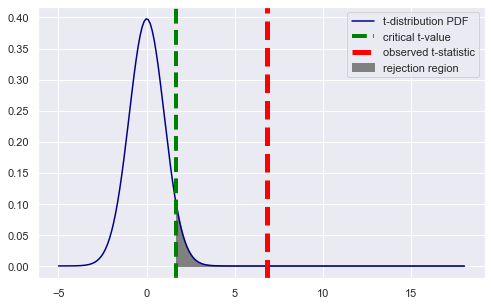

In [48]:
t_stat= (x_bar -  mu)/(sd/np.sqrt(n))
t_crit = st.t.ppf(1 - 0.05, df=99)
print('The T-Statistic is =', t_stat)
print('The critical T value is =', t_crit)
if t_stat <= t_crit:
    print('We fail to reject the Null hypothesis because our T statistic is less than the citical T value.')
else: 
    print('We reject the Null hypothesis because our T statistic is in the reject zone!')
    
fig, ax = plt.subplots(figsize=(8,5))

x = np.linspace(-5, 18, 200)
y = st.t.pdf(x, df, 0, 1)

ax.plot(x, y, color='darkblue', label="t-distribution PDF")
ax.axvline(t_crit,color='green',linestyle='--',lw=4,label='critical t-value')
ax.fill_betweenx(y,x,t_crit,where=x > t_crit,color="gray",label="rejection region")
ax.axvline(t_stat, color='Red', linestyle='--', lw=5,label='observed t-statistic')

ax.legend();

## Conclusion for Recommendation #1:

Based on our statistical analysis Computing Vision should strive to have movie runtime between 119 - 130 minutes to increase net revenue and ratings for its upcoming film catalog.

## Recommendation #2: Genre Type

In this section we used data analysis to find out if there was difference in genre type based on the top 100 most profitable and highly rated movies overall. We will do this by taking all of the genres classified to each movie and counting them.

We wanted to see if the difference would affect which types of movie genre(s) Computing Vision should pursue for their new movie studio.

In [25]:
#Merge movie ratings with movie basics to look at the coorelation with rating and genre
movie_rating_info = pd.merge(movie_basics, movie_ratings, how="inner", on='movie_id')
movie_rating_info

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",8.7,136
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,NaN,6.6,5


We start our analysis by taking the top 100 movies based on rating.

In [26]:
#Movies sort by most votes and average rating
movie_rating_info_sorted = movie_rating_info.sort_values(by=['numvotes', 'averagerating'], ascending=False)
#Top 100 movies selected based on rating
top_100_pop = movie_rating_info_sorted.iloc[:100]
#Top 100 rated movies sorted by movie rating
top_100_pop = top_100_pop.sort_values(by='averagerating', ascending=False)
#Index rest for top 100 rated movies
top_100_pop = top_100_pop.reset_index().drop(columns='index')
#Select columns renamed for consistency among columns
top_100_pop = top_100_pop.rename(columns={'numvotes': 'num_votes', 'averagerating': 'avg_rating'})

We then split our genre column so that the genres are seperated to be able to count the number of times each genre occurs in the top 100 movies.

In [27]:
#Declaring new variable to split genre data into separate columns
pop_string_split = top_100_pop
#Splitting genre values into new columns
pop_genre_split = pop_string_split["genres"].str.split(",", n = 3, expand = True)
#Concatinated genre columns into 1 series
top_100_pop_genres = pd.concat([pop_genre_split[0], pop_genre_split[1], pop_genre_split[2]])
#Dropna from genre series
top_100_pop_genres = top_100_pop_genres.dropna()
#Counting genre counts in top 100 movie list
top_100_pop_genre_counts = top_100_pop_genres.value_counts()

From here, we know that the highest rated movie genre is Adventure, followed closely by Action.

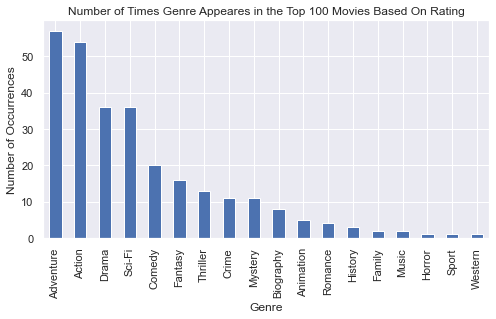

In [28]:
#Bar plot of top 100 genre counts based on popularity
top_100_pop_genre_counts.plot(kind='bar', figsize=(8, 4), 
                             title='Number of Times Genre Appeares in the Top 100 Movies Based On Rating')
plt.xlabel('Genre')
plt.ylabel('Number of Occurrences');

We will now also do this analysis of genres based of the top 100 highest revenue movies.

We start by taking out the dollar signs and commas from the production budget, worldwide gross, and domestic gross and converting the column values from objects to floats to analyse using math.

In [29]:
#Removing dollar signs and commas from production budget column values
budgets['production_budget'] = budgets['production_budget'].str.replace('$','')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$','')
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace('$','')
budgets['production_budget'] = budgets['production_budget'].str.replace(',','')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',','')
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(',','')
#Dropping uneccesary rows
budgets = budgets.drop(columns=['id', 'release_date'])
# Rename movie row to primary_title for consistency with previous tables
budgets = budgets.rename(columns={'movie': 'primary_title'})
#Changing datatypes to floats
budgets['production_budget'] = budgets['production_budget'].astype(float)
budgets['domestic_gross'] = budgets['domestic_gross'].astype(float)
budgets['worldwide_gross'] = budgets['worldwide_gross'].astype(float)

Now that we have our column values into floats, we can create a net revenue column.

In [30]:
#Adding net revenue column
net = budgets.worldwide_gross - budgets.production_budget
budgets['net_revenue'] = net

After creating the net revenue column, we will merge the movie basics table in with our budgets table to look at the genres compared to revenue.

In [31]:
#Merge movie basics with budget
movie_revenue_info = pd.merge(movie_basics, budgets, how="inner", on='primary_title')
movie_revenue_info

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,production_budget,domestic_gross,worldwide_gross,net_revenue
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",45000000.0,0.0,73706.0,-44926294.0
1,tt0293429,Mortal Kombat,Mortal Kombat,2021,NaN,"Action,Adventure,Fantasy",20000000.0,70433227.0,122133227.0,102133227.0
2,tt0326592,The Overnight,The Overnight,2010,88.0,NaN,200000.0,1109808.0,1165996.0,965996.0
3,tt3844362,The Overnight,The Overnight,2015,79.0,"Comedy,Mystery",200000.0,1109808.0,1165996.0,965996.0
4,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",25000000.0,720828.0,9313302.0,-15686698.0
...,...,...,...,...,...,...,...,...,...,...
3810,tt9678962,Fuel,Fuel,2018,NaN,"Documentary,Sport",2500000.0,174255.0,174255.0,-2325745.0
3811,tt9729206,Diner,Diner,2019,NaN,Crime,5000000.0,12592907.0,12592907.0,7592907.0
3812,tt9805168,Traitor,Traitor,2015,110.0,"Action,Drama,Romance",22000000.0,23530831.0,27882226.0,5882226.0
3813,tt9844102,Ray,Ray,2018,111.0,Crime,40000000.0,75305995.0,124823094.0,84823094.0


In [32]:
#Drop Duplicate Titles
movie_revenue_info = movie_revenue_info.drop_duplicates(subset=['primary_title'])

We start this analysis by taking the top 100 movies based on rating.

In [33]:
#Movies sorted by net revenue
revenue_sorted = movie_revenue_info.sort_values(by='net_revenue', ascending=False)
#Top 100 movies selected
top_100_rev = revenue_sorted.iloc[:100]
#Top 100 movies sorted specifically by movie rating
top_100_rev = top_100_rev.reset_index().drop(columns='index')

We then split our genre column so that the genres are seperated to be able to count the number of times each genre occurs in the top 100 movies.

In [34]:
#Declaring new variable to split genre data into separate columns
string_split_rev = top_100_rev
#Splitting genre values into new columns
genre_split_rev = string_split_rev["genres"].str.split(",", n = 3, expand = True)
#Concatinated genre columns into 1 series
top_100_rev_genres = pd.concat([genre_split_rev[0], genre_split_rev[1], genre_split_rev[2]])
#Drop na from genre series
top_100_rev_genres = top_100_rev_genres.dropna()
#Counting genre counts in top 100 movie list
top_100_rev_genre_counts = top_100_rev_genres.value_counts()

Once again, we see that the highest grossing movie genre is Adventure, followed closely by Action. 

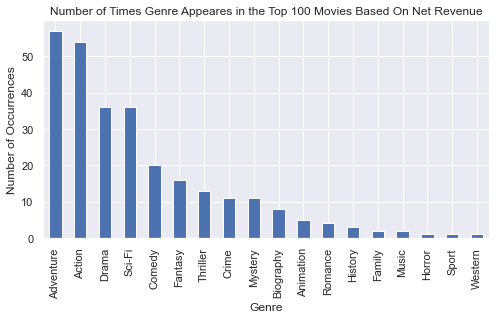

In [35]:
#Bar plot of top 100 genre counts based on Net Revenue
top_100_pop_genre_counts.plot(kind='bar', figsize=(8, 4),
                             title='Number of Times Genre Appeares in the Top 100 Movies Based On Net Revenue')
plt.xlabel('Genre')
plt.ylabel('Number of Occurrences');

Although the top two are the same, the count for each is different, and the genres following are in a different order. To understand this, we will add the two findings together and create a new data visualization.

In [36]:
#Concatenate the two results together
movie_genres = pd.concat([top_100_rev_genre_counts, top_100_pop_genre_counts], axis=1)
#Change all null values to zero to represent that there are none in the top 100 movies in that category
movie_genres = movie_genres.fillna(0)
#Renaming the column names to reflect which came from the rating results and the revenue results
movie_genres.rename(columns= {0 : 'Revenue', 1 : 'Rating'}, inplace=True)

This graph gives us a side by side comparison between the number of times a genre occurs based off of revenue and rating.

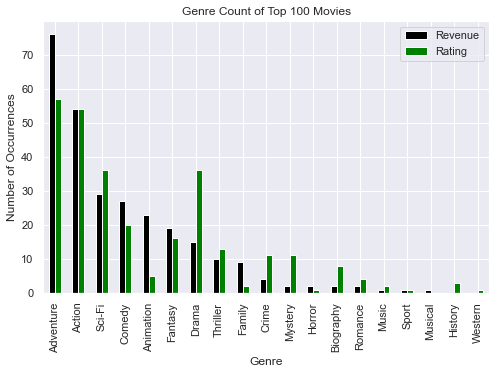

In [37]:
#Plot the count of revenue and rating in each genre side by side to see which genres are the most popular and most profitable
movie_genres.plot(kind='bar', title='Genre Count of Top 100 Movies', color = ['Black','Green'])
plt.xlabel('Genre')
plt.ylabel('Number of Occurrences');

### Conclusion for Recomendation #2:
This graph confirms that although the two graphs looked similar standing alone, when combined, they are visually different. We can use this information to recommend that Computing Vision pursue making movies in the Adventure and Action genre.

## Recomendation #3: